#### Isaac Rand
#### 15 May 2020
#### GIS 3
------------
## Using Python to Examine Population Distribution By Race in the Area Around Riverside City California
----------------------

## Setup

I recommend running this notebook in [this binder environment](https://mybinder.org/v2/gh/sjsrey/pysalnarsc19/master). It has all of the libraries set up and ready to go as well as the data used here pre installed. Just upload the notebook into the content folder and you are all ready to go. Heads up, it may take a few minutes to load.


### Imports
This project uses matplotlib, numpy, pandas, geopandas, and pySAL. They are imported below:


In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pysal.viz import mapclassify
from pysal.viz.splot.mapping import vba_choropleth



/srv/conda/envs/notebook/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/srv/conda/envs/notebook/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


### Reading Data

The project is dependent on data stored in [the binder environment mentioned above](https://mybinder.org/v2/gh/sjsrey/pysalnarsc19/master). Even if you do not run your notebook in this environment, the data can be downloaded from its data folder (within the content folder). 

All of the data files used here are spatial, and are read in using geopandas' specialized read file function `gpd_read_file()` to turn them immediately into geodataframes.


In [2]:
tracts = gpd.read_file('data/clinics.shp')
city = gpd.read_file('data/riverside_city.shp')
print("tracts crs: ", tracts.crs)
print("city crs: ", city.crs)

tracts crs:  {'init': 'epsg:4269'}
city crs:  {'init': 'epsg:4269'}


Our data files are in EPSG:4269, which uses angular degrees as its usit of measurement. Let's change their CRS to EPSG:2227, a projection designed for the state of California (where the data is from) and which uses feet as units, so that we can work with concrete distances later.

In [3]:
tracts = tracts.to_crs("EPSG:2227")
city = city.to_crs("EPSG:2227")
print("tracts crs: ", tracts.crs)
print("city crs: ", city.crs)

/srv/conda/envs/notebook/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


tracts crs:  EPSG:2227
city crs:  EPSG:2227


/srv/conda/envs/notebook/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Data Preparation

Right now, our tracts data frame contains all of the tracts in Riverside County, California, but for our purposes we are only interested in the area in and around Riverside City (within that county). 

### Extending the City Border

The borders of Riverside City are contained in the `city` geodataframe. In order to study the greater Riverside City area we will buffer the geometry stored in `city` by 2 miles. This has the effect of extending the city's border by 2 miles. Since the CRS uses feet as its unit of measurement, we pass the `buffer()` method 10560 (the number of feet in two miles).

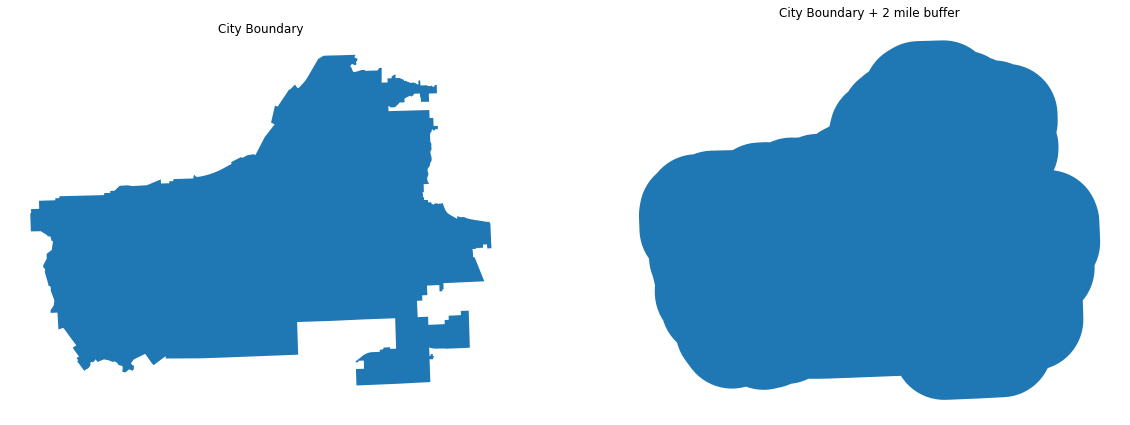

In [4]:
fig, axs = plt.subplots(1,2, figsize=(20,10)) #create a new figure, one row and two columns

city_area = city.buffer(10560)                        #buffer city area by 2 miles, this results in a GeoSeries
city_area = gpd.GeoDataFrame(geometry = (city_area))  #convert the geoseries to a geodataframe
city_area["pop2010"] = city.Pop2010                   #Add the population data from the non-buffered geodataframe to the buffered one
city.plot(ax = axs[0])                                #show original city borders on left
city_area.plot(ax=axs[1])                             #show buffered city borders on right

#set figure style
axs[0].set_title('City Boundary')
axs[0].set_axis_off()
axs[1].set_title('City Boundary + 2 mile buffer')
axs[1].set_axis_off()

# show plot
plt.show()

### Clipping Tracts File to Expanded City Boundary

We want to look at the area nearby Riverside City by census tracts, using the shapes and attribute data stored in the `tracts` geodataframe. To do this, we will execute a spatial join of the `tracts` geodataframe with the `city_area` geodataframe. By using the `inner` join method and the `intersects` spatial join criteria, we will select only the elements of both dataframes which intersect both `tracts` and `city_area`

<bound method NDFrame.head of          GEOID10           NAMELSAD10     ALAND10  AWATER10   INTPTLAT10  \
0    06065042012  Census Tract 420.12   2687173.0       0.0  +33.9108776   
3    06065040816  Census Tract 408.16   1788821.0       0.0  +33.9024569   
4    06065040815  Census Tract 408.15   1266779.0       0.0  +33.8930776   
5    06065040814  Census Tract 408.14   1088363.0       0.0  +33.8973552   
6    06065040813  Census Tract 408.13  12539455.0    3687.0  +33.9155438   
..           ...                  ...         ...       ...          ...   
416  06065030601  Census Tract 306.01  13797155.0       0.0  +33.9200472   
429  06065042217  Census Tract 422.17   5036136.0       0.0  +33.9278407   
430  06065042013  Census Tract 420.13   2972803.0       0.0  +33.8944124   
443  06065040809  Census Tract 408.09   2391185.0       0.0  +33.8928291   
444  06065040901  Census Tract 409.01   2104102.0       0.0  +33.9133540   

       INTPTLON10  DP0010001  DP0010002  DP0010003  DP001

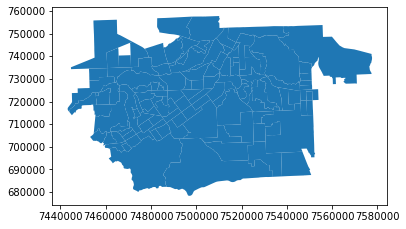

In [5]:
city_ar_tracts = gpd.sjoin(tracts, city_area, how='inner', op='intersects')
city_ar_tracts.plot()
city_ar_tracts.head

As you can see, the resulting geodataframe `city_ar_tracts` contains all of the columns of both `city_area` and `tracts` in each row. This means that the information of the `pop2010` field, which was the same across `city_area` is copied over again in each of the 444 rows. Here, we copied `pop2010` explicitly and it does not really matter that it is wasting memory for the purpose of this tutorial, but it is worth looking out for extra columns in your own practice. You can drop unwanted columns as shown in the code below:

In [6]:
city_ar_tracts = city_ar_tracts.drop('pop2010', axis = 1)
city_ar_tracts.head

<bound method NDFrame.head of          GEOID10           NAMELSAD10     ALAND10  AWATER10   INTPTLAT10  \
0    06065042012  Census Tract 420.12   2687173.0       0.0  +33.9108776   
3    06065040816  Census Tract 408.16   1788821.0       0.0  +33.9024569   
4    06065040815  Census Tract 408.15   1266779.0       0.0  +33.8930776   
5    06065040814  Census Tract 408.14   1088363.0       0.0  +33.8973552   
6    06065040813  Census Tract 408.13  12539455.0    3687.0  +33.9155438   
..           ...                  ...         ...       ...          ...   
416  06065030601  Census Tract 306.01  13797155.0       0.0  +33.9200472   
429  06065042217  Census Tract 422.17   5036136.0       0.0  +33.9278407   
430  06065042013  Census Tract 420.13   2972803.0       0.0  +33.8944124   
443  06065040809  Census Tract 408.09   2391185.0       0.0  +33.8928291   
444  06065040901  Census Tract 409.01   2104102.0       0.0  +33.9133540   

       INTPTLON10  DP0010001  DP0010002  DP0010003  DP001

### Renaming Columns

As you may have noticed above, the attributes from the `tracts` geodataframe have many long and unclear names. We will rename the two columns of interest to us below for our own reference. We will be exploring the populations in each tract which identify as one race, White or Black. If you are interested in the other variables, a full list is given [here](http://magic.lib.uconn.edu/magic_2/vector/37800/demogprofilehousect_37800_0000_2010_s100_census_1_t.htm)

In [7]:
city_ar_tracts.rename(columns={'DP0080003':'whitePop'}, inplace=True)
city_ar_tracts.rename(columns={'DP0080004':'blackPop'}, inplace=True)

## Data Visualization

### Choropleth Maps of One Variable

Now that we have all of the tracts within a 2 mile radius of Riverside, we can turn our attention to visualizing that data. Below is how the `plot()` method allows us to make simple maps of variables one at time.

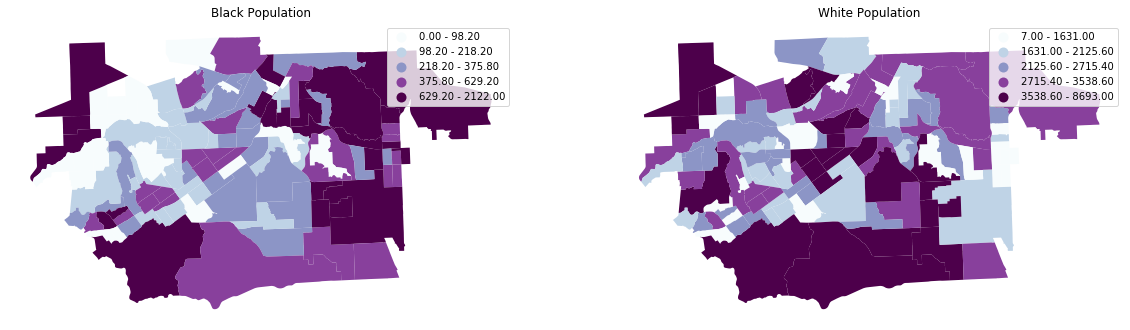

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20,10)) #create a new figure, one row and two columns

# making choropleth maps of single variables, using scheme=quartiles classifies 
# each variable into 5 groups with an equal number of tracts in each group. The number of groups 
# can be changed by adding a paramerter `k`
city_ar_tracts.plot(column = "blackPop", scheme = "quantiles", ax = axs[0], cmap = "BuPu", legend = True)   
city_ar_tracts.plot(column = "whitePop", scheme = "quantiles", ax=axs[1], cmap = "BuPu", legend = True)      

#set figure style
axs[0].set_title('Black Population')
axs[0].set_axis_off()
axs[1].set_title('White Population')
axs[1].set_axis_off()

# show plot
plt.show()

From these two maps, it is not entirely easy to spot those tracts in which there are many people of both races, or those which are high in one population but low in another. To make the comparison of these two variable easier we will use pySAL's methods for making "bivariate choropleth" maps, in which information about two variables is displayed in one map.

### Choropleth Maps of Two Varibales

Bivariate choropleth maps can be made with pySAL by using one variable to determine the color of a tract, and another variable to determine it's alpha value (or it's transparency). This is done using the `vba_choropleth` function. 

The first value passed to this function is the variable to be mapped using color, and the second is the variable to be mapped using transparency. By default, a tract fades into transparency as this variable decreases as seen on the legend below -- this can be changed with the `revert_alpha = True` argument.

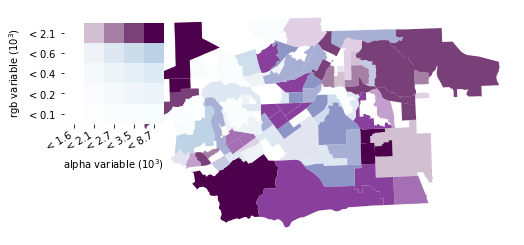

In [16]:
f, ax = plt.subplots(1, figsize=(7, 7))
vba_choropleth(city_ar_tracts.blackPop, city_ar_tracts.whitePop, city_ar_tracts, rgb_mapclassify=dict(classifier='quantiles'),
               alpha_mapclassify=dict(classifier='quantiles'),
               cmap='BuPu', ax=ax, legend = True)
plt.show()

The resulting map allows us to quickly compare the values of the total white population and total black population in each tract. The darkest purple areas are high in both groups, and are likely areas of high population density (quite possibly not one's of real integration). The lighter purple represents areas with high populations of black people relative to the others (in the highest quantile) but lower values of white populations. These are likely areas of segregation. 

One weakness of this map is that it is very hard to tell apart the areas which are high in the alpha variable (white population) based on their differences in the rgb variable (black popultion). Since all of these variables are faded, it is hard to tell what their color is.

### That's It!

You can now make some simple bivariate choropleth maps and clean some data! Be careful using the choropleth maps with just one variable, because it can be hard and take a lot of time to compare one to another. Be even more careful bivariate choropleth maps, as they can sometimes be so hard to interpret they mask the true pattern. I highly recommend making two maps whenever you use bivariate choropleth maps one with each variable as the rgb variable and the other as the alpha variable. This will help you not to miss as much :)